In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sns.set()

In [156]:
data = pd.read_csv('disthistogram', header=0 , delimiter='\t', names=['Harmonic','Arithmetic','Geometric','VeinOrder','NN VeinOrder','v2x','v2y','vx','vy','v2width','vwidth'])

x = data.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data = pd.DataFrame(x_scaled, columns=data.columns)

In [161]:
data

,Harmonic,Arithmetic,Geometric,VeinOrder,NN VeinOrder,v2x,v2y,vx,vy,v2width,vwidth
0,4.90509,5.11648,5.00967,1,2,23.49610,43.20380,20.28390,40.69390,1.399650,3.952525e-322
1,4.92825,5.13232,5.02925,2,2,23.51610,43.23080,20.28390,40.69390,1.292850,3.952525e-322
2,5.27658,5.59885,5.44950,2,2,23.45300,41.42380,20.28390,40.69390,0.310848,3.952525e-322
3,4.18668,4.88015,4.49807,1,2,21.74790,43.34930,20.28390,40.69390,1.342950,3.952525e-322
4,4.72558,4.92960,4.83095,2,2,23.39080,39.67070,20.28390,40.69390,0.284837,3.952525e-322
5,5.16008,5.18875,5.17440,2,2,25.26980,43.18690,28.53060,39.66030,1.292850,3.952525e-322
6,4.31853,4.39386,4.35595,2,2,23.57250,37.95150,20.96920,35.36590,0.271128,3.952525e-322
7,3.88394,5.88200,4.78604,1,2,20.07330,42.91990,20.28390,40.69390,1.338830,3.952525e-322
8,5.44641,6.30957,5.89241,2,2,26.93480,42.72150,28.53060,39.66030,1.286490,3.952525e-322
9,3.92030,4.19581,4.05791,3,2,23.57390,36.24740,21.72280,34.48940,0.117059,3.952525e-322


In [157]:
data.iloc[0][5:9:2]

v2x    23.4961
vx     20.2839
Name: 0, dtype: float64

In [158]:
data.iloc[0][6:9:2]

v2y    43.2038
vy     40.6939
Name: 0, dtype: float64

In [190]:
cols = list(data.columns[1:7])
cols += list(data.columns[9:])
cols

['Arithmetic',
 'Geometric',
 'VeinOrder',
 'NN VeinOrder',
 'v2x',
 'v2y',
 'v2width',
 'vwidth']

In [191]:
countdf = data.groupby(['vx','vy']).agg('count').drop(cols,axis=1).rename(columns={'Harmonic':'count'})
countdf.head(5)
#countdf.index

,,count
vx,vy,
4.29158,35.8589,49
4.69666,34.9815,6
5.04553,34.0610,5
5.30879,32.0865,11
5.35695,33.1077,6


In [192]:
copycountdf = countdf.copy()
#copycountdf['vx','vy'] = copycountdf.index
copycountdf.reset_index(level=0, inplace=True)
copycountdf.reset_index(level=0, inplace=True)

In [110]:
copycountdf.head(5)

,vy,vx,count
0,35.8589,4.29158,49
1,34.9815,4.69666,6
2,34.0610,5.04553,5
3,32.0865,5.30879,11
4,33.1077,5.35695,6


In [193]:
cdata = data.copy()

In [194]:
data = pd.merge(cdata,copycountdf,on=['vx','vy'])

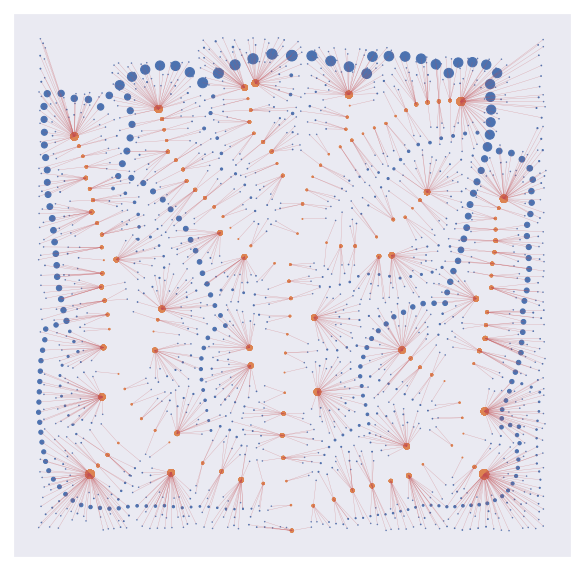

In [206]:
fig = plt.figure(figsize=(10,10))
plt.scatter(data['v2x'],data['v2y'],s=np.power(10*np.array(data['v2width']),1.79))
plt.scatter(data['vx'],data['vy'],s=data['count'])
for i in range(data.shape[0]):
    plt.plot(data.iloc[i][5:9:2],data.iloc[i][6:9:2],'-r',linewidth=0.3,alpha=0.5,)
plt.xticks([])
plt.yticks([])
plt.show()

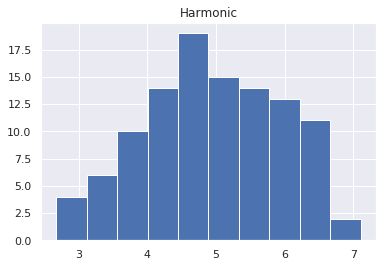

In [14]:
data.groupby(['VeinOrder','NN VeinOrder']).get_group((2,3)).drop(['VeinOrder','Geometric','Arithmetic','NN VeinOrder'],axis=1).hist(bins=10)
#plt.xlim(1,6)
plt.show()
#data['NN VeinOrder'].hist(bins=10)
#plt.xlim(1,5)
#plt.show()

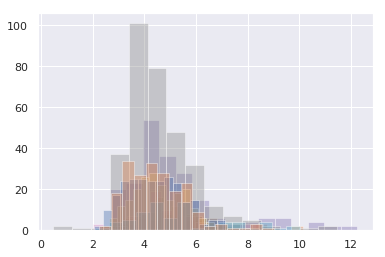

In [19]:
for i in range(1,5):
    for j in range(1,4):
        df = data.groupby(['VeinOrder','NN VeinOrder']).get_group((i,j)).drop(['VeinOrder','Geometric','Arithmetic','NN VeinOrder'],axis=1)
        sns.distplot(df, bins=15,hist=True, kde=False, rug=False)

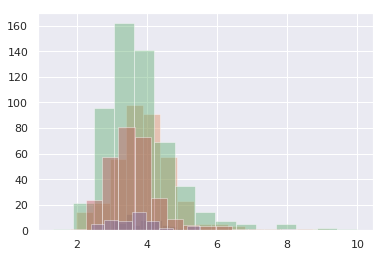

In [100]:
for i in range(1,6):
    df = data.groupby('VeinOrder').get_group(i).drop(['VeinOrder','Geometric','Arithmetic','NN VeinOrder'],axis=1)
    sns.distplot(df, bins=15,hist=True, kde=False, rug=False)



In [53]:
data.describe()

,Harmonic,Arithmetic,Geometric,VeinOrder,NN VeinOrder
count,1339.000000,1339.000000,1339.000000,1339.000000,1339.00000
mean,3.814889,4.091761,3.949626,2.908887,2.45183
std,0.950355,0.956059,0.949267,0.920163,0.77693
min,1.324530,1.804050,1.637970,1.000000,1.00000
25%,3.195470,3.515505,3.372795,2.000000,2.00000
50%,3.683680,3.983070,3.827150,3.000000,2.00000
75%,4.198680,4.506980,4.352100,3.500000,3.00000
max,9.997340,9.997340,9.997340,6.000000,4.00000


In [49]:
data.head()

,Harmonic,Arithmetic,Geometric,VeinOrder,NN VeinOrder
0,4.67798,4.72853,4.70258,2,2
1,4.64436,4.64436,4.64436,1,3
2,2.68025,3.43605,3.09173,2,2
3,4.92177,4.94629,4.93402,1,3
4,3.91793,4.11680,4.01123,3,2


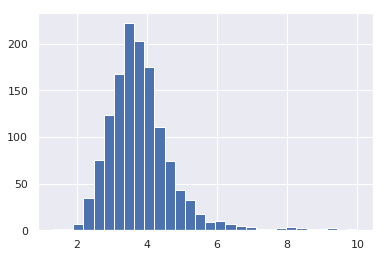

In [91]:
data['Harmonic'].hist(bins=30)
plt.show()


In [22]:
data.mean()

Distances Histogram    3.814889
dtype: float64

In [23]:
data.describe()

,Distances Histogram
count,1339.000000
mean,3.814889
std,0.950355
min,1.324530
25%,3.195470
50%,3.683680
75%,4.198680
max,9.997340


In [24]:
data.median()

Distances Histogram    3.68368
dtype: float64

In [28]:
data.kurtosis()

Distances Histogram    6.198549
dtype: float64

In [29]:
data.skew()

Distances Histogram    1.737346
dtype: float64